In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.ticker as mtick

import jax
from jax import random 
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from censored_demand.rental_model import RentalInventory
from censored_demand.plotting import plot_rentals

az.style.use("arviz-darkgrid")

/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_45192/3520726664.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/kylejcaron/Library/Caches/pypoetry/virtualenvs/censored-demand-2hs-RL0I-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Modeling Inventory Demand under extreme stockouts

__The Problem:__ You work at a clothing rental service that is suffering from high periods of churn. You've found that stockouts are one of the biggest reasons for churn - despite having plenty of options available, each product tends to be stocked out more than 70% of the time. __How can we determine how much stock to reorder?__

The idea of this project is to borrow ideas from discrete choice literature, survival analysis, demand modeling, and simulation. Products with extreme stockouts have misleading demand estimates under classic demand models. The basis of these ideas is really simple. If we only have 5 units of a product in stock, and we saw 5 sales (or rentals in this case) that day, then we know that demand is atleast 5 rentals. Typical demand modeling might only look at the count of rentals each day, while censored demand modeling would look at both rental counts and stock levels, and incoporate both of these pieces of information. 

The idea is to start simple(-ish) and add complexity. We'll first model a single product and test different ordering policies, and then begin modeling multiple products. 

# Part 1: Looking at the data

---

Let's look at the data for a single product

We have two datasets:
 * `rentals` showing rental events and when those rentals were returned for a single product
 * `stock` showing available stock levels for that product over time

Remember, this is a rental product, so units flow back and forth between inventory and customers.


In [2]:
stock = pd.read_csv("data/stock_levels.csv").assign(date=lambda d: pd.to_datetime(d.date))
stock.head()

,date,units,ending_units
0,2022-04-01,100,88
1,2022-04-02,88,75
2,2022-04-03,75,63
3,2022-04-04,63,53
4,2022-04-05,55,50


In [3]:
rentals = pd.read_csv("data/rentals.csv").assign(date=lambda d: pd.to_datetime(d.date))
rentals.head()

,rental_id,date,return_date
0,30e3af99-df18-4b5c-8203-8c6d5c38921f,2022-04-01,2022-04-05
1,378e657b-4d22-438d-b26f-2602a0000db1,2022-04-01,2022-04-09
2,da3419e6-b58b-45c1-8067-073b1f1d1529,2022-04-01,2022-04-10
3,b2e7a4c8-dc9e-4ee7-b135-baddf2d34c5a,2022-04-01,2022-04-11
4,4abaa554-d936-4595-9e22-0ad78cd6a03d,2022-04-01,2022-04-13



Note that this is fake data, and it was kind of hard to simulate. Its missing obvious things like a product id, and a unit id right now.

We can combine both of the tables and plot a time series of whats happening. 

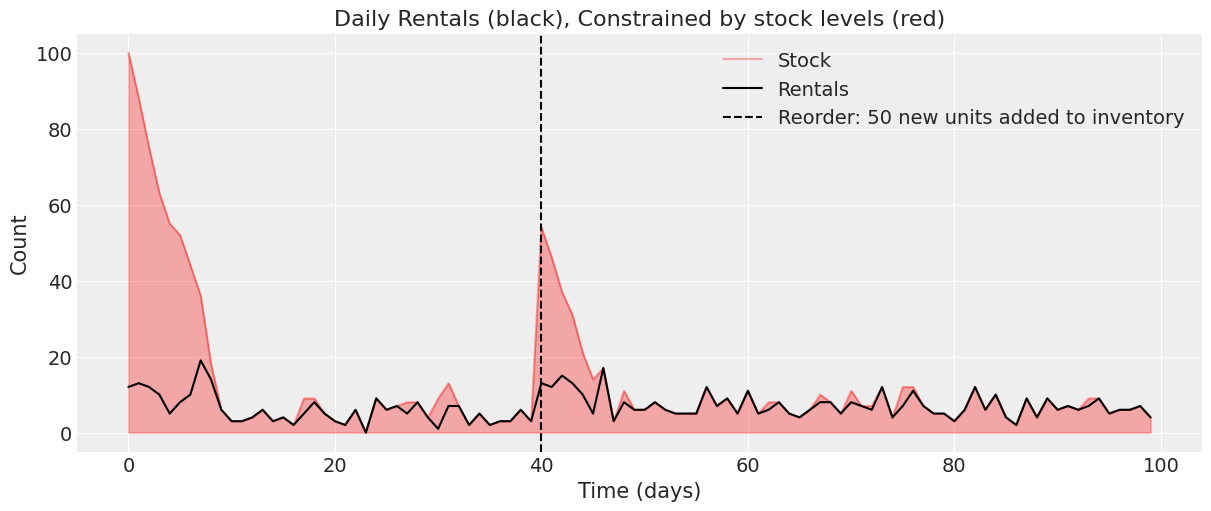

In [4]:
daily_rentals = rentals.resample("D",on='date')['rental_id'].count()
ax = plot_rentals(daily_rentals, stock.units)
ax.axvline(40, color='k', ls='--', label='Reorder: 50 new units added to inventory')
plt.legend()
plt.show()

For most of the days in the product's lifetime, there are as many rentals as there are units available. This indicates we're probably understocked - if we had more stock available, we'd likely observe more rental demand. 

This is also apparent in the overstocked periods - at the start of the products lifetime there tends to be more rentals. There's also a __reorder__ that happens at t=40, where the business procured 50 new units of that product to rent out to customers. We can see that there's a jump in observed rental demand 

It's time to introduce a key concept - the difference between unconstrained rental demand and observed rental demand. 
 * __Unconstrained rental demand__ is the true demand to rent the product each day.
 * __Observed rental demand__ is the number of rentals we actually observe in the data, after demand gets constrained by stock levels, and random noise

# Part 2: Modeling the problem 
---

First, lets reiterate our goal. We want to know how many more units to purchase for this rental product so we dont end up with any more stockouts. To do so, we need to know what stock levels will be if we have more units in stock

$$
E[\text{stock}_t | \text{do(stock}_0=X), \text{demand}_{t-1},\text{stock}_{t-1}, \text{active rentals}_{0:t}]
$$

When we think of the __data generating process__ for rental demand and stock levels its the following: 
 1. Customers come in and rent $y \sim \text{min}(\text{Poisson}(\lambda), \text{stock})$ units each day
 2. Those units tend to have some learnable distribution of rental duration, $t \sim \text{LogNormal}(\theta, \sigma)$
 3. The stock levels vary as those rentals occur and get returned

This narrows the problem down - we need to identify unconstrained rental demand (how many rentals would we get if we had perfect stock), and rental duration. We can use models for both of these and then simulate different potential outcomes

__Here's a brief glimpse at the overall plan__
 1. Fit a rental duration model
 2. Fit a censored demand model
 3. Combine both of those into a stock level simulation
 4. Simulate out different purchase volumes that lead to a low chance of stockouts. 
 5. Purchase that volume of units
 6. Expand the model to incorporate many products
 7. Increase the complexity of the simulation and the model - i.e. what happens if we add seasonality to the demand? What happens if there are demand shocks?

## Rental Duration Model

Our plan for now is to model the unconstrained demand for this single product - whats the actual rental demand for the product? How many rentals would it get if there werent stockouts? Lets start off by looking at our data

In [5]:
rentals.sample(10, random_state=99)

,rental_id,date,return_date
539,b7f78d8c-2bc6-4fa3-9186-79d7a25443ab,2022-06-18,2022-06-29
386,45e6747b-8ed4-4476-9635-1f695ace8a3e,2022-05-27,2022-06-16
612,091b5e22-7a13-4e02-bbbf-8ca590729907,2022-06-29,NaN
219,afbe6021-4858-4fd0-b4b9-615d503a92f0,2022-05-05,2022-05-13
166,39ea9335-30e9-4b91-8883-c59ea168638c,2022-04-25,2022-05-07
195,2c283ffe-2473-4b58-88f7-7df9ec961904,2022-04-29,2022-06-08
617,ad4528c9-1ae4-4dc4-893a-17fca3714ccb,2022-06-30,NaN
377,74b83f11-d13f-45bc-b681-20d10f565fde,2022-05-26,2022-06-25
632,335eacf3-101a-452e-b80d-2cf0386eb5ae,2022-07-02,NaN
510,2b5439c6-4080-4039-9770-cd9ac934a21f,2022-06-14,2022-06-26


Its easy to see that there are plenty of rentals that are still out with customers and havent been returned yet. For these unreturned rentals, we cant calculate an accurate rental duration.

Its important to remember that even those these items arent returned, some have been rented out for 30, 40, 50 days, and its important information to know that some items have been out for atleast that long. A good example is that if its possible for some items to be rented out for 200 days, but we've only observed 100 days of activity, then whatever we estimate for the rental duration would be underestimated if we just used simple averaging. 

What we can instead do is calculate the rental duration to-date and then use a survival model to properly incorporate those unreturned items.

In [6]:
curr_date = rentals.date.max()
rentals = (
    rentals
    .assign(return_date=lambda d: pd.to_datetime(d.return_date))
    .assign(time_since=lambda d: (d.return_date.fillna(curr_date)-d.date).dt.days)
    .assign(event=lambda d: d.return_date.notnull()*1)
)
rentals

,rental_id,date,return_date,time_since,event
0,30e3af99-df18-4b5c-8203-8c6d5c38921f,2022-04-01,2022-04-05,4,1
1,378e657b-4d22-438d-b26f-2602a0000db1,2022-04-01,2022-04-09,8,1
2,da3419e6-b58b-45c1-8067-073b1f1d1529,2022-04-01,2022-04-10,9,1
3,b2e7a4c8-dc9e-4ee7-b135-baddf2d34c5a,2022-04-01,2022-04-11,10,1
4,4abaa554-d936-4595-9e22-0ad78cd6a03d,2022-04-01,2022-04-13,12,1
...,...,...,...,...,...
672,65e342c3-33b7-4b58-b769-581c7ddefbdc,2022-07-08,NaT,1,0
673,8250947e-9b57-4c9b-b8e6-f1036eac3063,2022-07-09,NaT,0,0
674,f2e7f974-4e27-4d3f-ae8c-490c64a9db38,2022-07-09,NaT,0,0
675,17826c61-b718-445b-b6e1-89cb0a2432e4,2022-07-09,NaT,0,0


We can write up a simple survival model in numpyro. The idea of survival analysis is that 
 * __if a return has already occurred__, we fit the model as usual with the observed rental duration.
 * __If a return hasnt occurred yet__, we tell the model that the rental duration is atleast as long as has been observed so far. This is done with stats via a survival function, or the complementary CDF (ccdf)

For simplicity, we're assuming the data is lognormally distributed (and we simulated the data that way). In reality, its best to plot distributions of your data and decide for yourself

In [7]:
def censored_lognormal(theta, sigma, cens, y=None):
    # If observed, this is the likelihood contribution
    numpyro.sample("obs", dist.LogNormal(theta, sigma).mask(cens != 1), obs=y)

    # If not observed, use the survival function as the likelihood constribution
    ccdf = numpyro.deterministic("ccdf", 1 - dist.LogNormal(theta, sigma).cdf(y))
    numpyro.sample("censored_label", dist.Bernoulli(ccdf).mask(cens == 1), obs=cens)

def survival_model(E, T=None):

    theta = numpyro.sample("theta", dist.Normal(2.9, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(0.7))
    with numpyro.plate("data", len(E)):
        censored_lognormal(theta, sigma, cens=(1-E), y=T)

We can now use numpyro to fit a model and estimate the typical rental duration. 

In [8]:
E = rentals.query("time_since>0").event.values
T = rentals.query("time_since>0").time_since.values


kernel = numpyro.infer.NUTS(survival_model)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True,
)
mcmc.run(random.PRNGKey(0),E=E,T=T)
idata = mcmc.get_samples()

/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_45192/3322487706.py:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|█████████████████████████████| 2000/2000 [00:00<00:00, 6723.14it/s, 7 steps of size 7.80e-01. acc. prob=0.93]


The true parameter values are covered by the model estimates, although they may be a little biased. Its possible my simulation code has a slight bug and should be double checked. However the estimated distribution is still pretty close to reality in this case and shouldnt impact too much for this demonstration

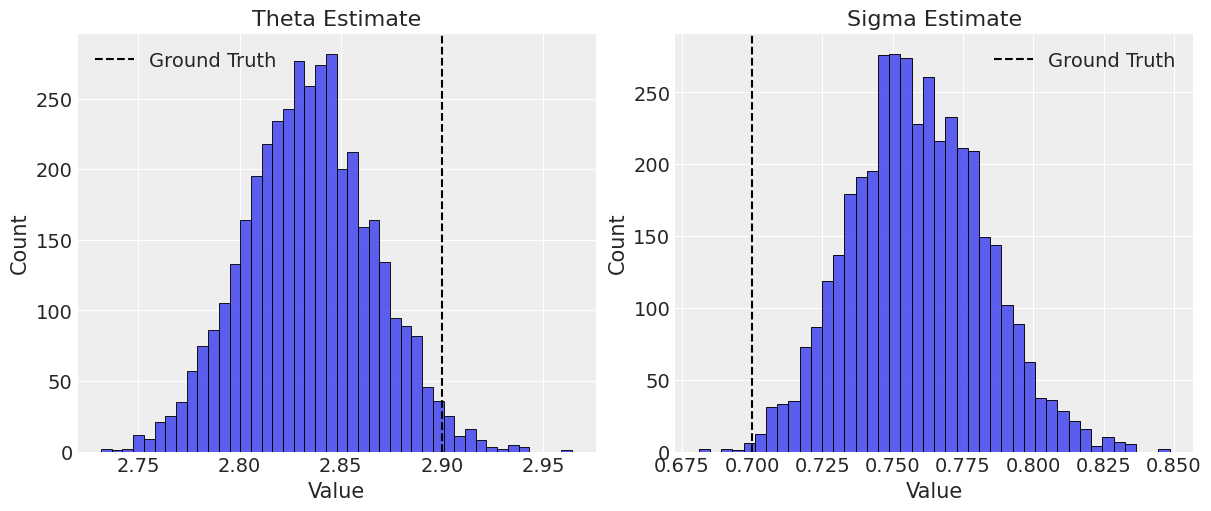

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.histplot( idata['theta'],ax=ax[0] )
ax[0].axvline(2.9,color='k', ls='--', label='Ground Truth')
ax[0].set(title="Theta Estimate", xlabel='Value')
ax[0].legend()

sns.histplot( idata['sigma'],ax=ax[1] )
ax[1].axvline(0.7,color='k', ls='--', label='Ground Truth')
ax[1].set(title="Sigma Estimate", xlabel='Value')
ax[1].legend()
plt.show()

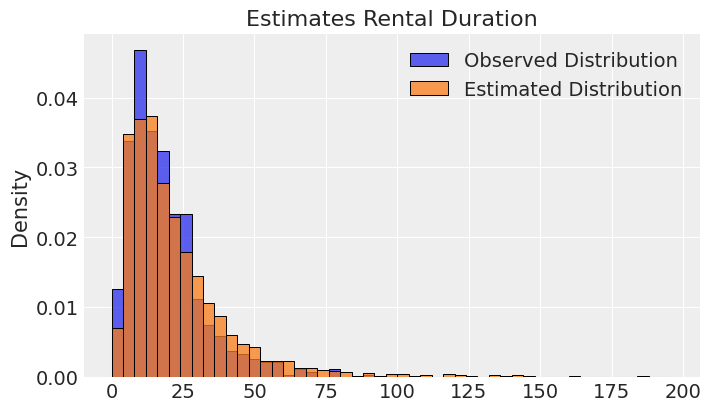

In [10]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

bins = np.arange(0,200,4)
sns.histplot(T, stat='density', label='Observed Distribution', bins=bins,ax=ax)

sns.histplot(
    dist.LogNormal(idata['theta'], idata['sigma']).sample(jax.random.PRNGKey(1)),
    stat='density',
    label='Estimated Distribution',
    bins=bins,
    ax=ax
)
ax.set_title("Estimates Rental Duration")
ax.legend()
plt.show()

Great, now we have a rental duration model fit, we just need to estimate demand

## Rental Demand Model

The rental demand model is going to start simple for this single-product case - we'll just estimate a poisson distribuion. 

Taking a look at the data again, its clear that demand is constrained, or censored, by stockouts here

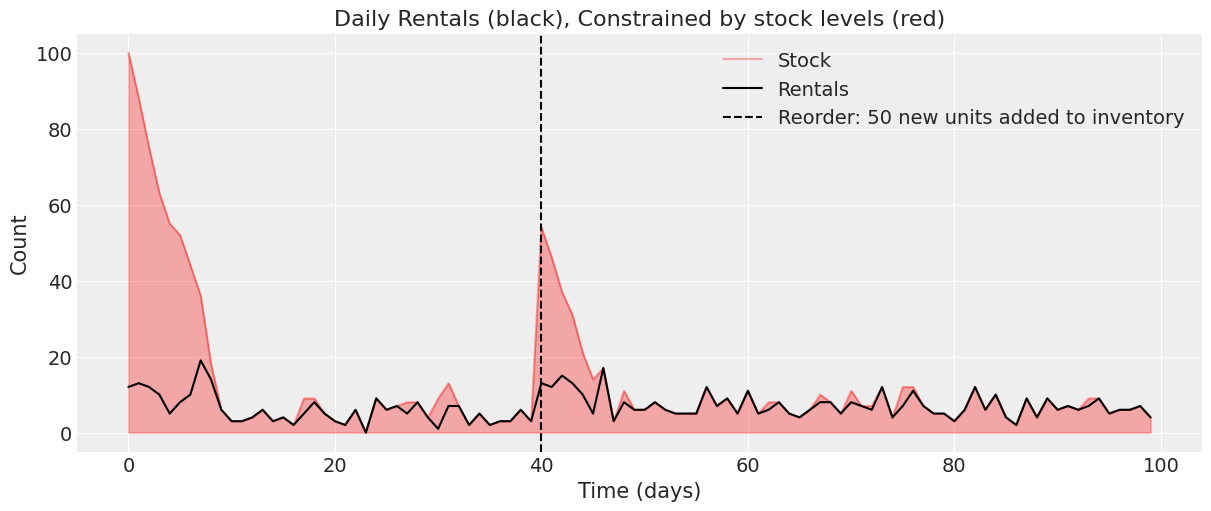

In [11]:
daily_rentals = pd.concat((
    rentals.resample("D",on='date')['rental_id'].count().rename("rentals"),
    stock.set_index("date").units,
),axis=1).assign(stockout=lambda d: d.units==d.rentals)

ax = plot_rentals(daily_rentals.rentals, daily_rentals.units)
ax.axvline(40, color='k', ls='--', label='Reorder: 50 new units added to inventory')
plt.legend();

To confirm this is the case, we can take a look at the typical number of rentals when there is a stockout vs. when there isnt - its clear that demand is much less on days when there are stockouts

In [12]:
(
    daily_rentals
    .groupby("stockout")
    .rentals.mean()
    .round(2)
)

stockout
False    9.21
True     5.82
Name: rentals, dtype: float64

We can leverage survival analysis again to estimate demand. We define a censored poisson model below that assumes demand is constant over time and if theres a stockout, the model thinks that demand is atleast as high as the rentals that day, otherwise if there's no stockout it thinks that demand is the number of rentals that day (plus some noise of course)

In [13]:
    
def censored_poisson(lambd, cens, y=None):
    # If observed, this is the likelihood contribution
    numpyro.sample("obs", dist.Poisson(lambd).mask(cens != 1), obs=y)

    # If not observed, use the survival function as the likelihood constribution
    ccdf = 1 - dist.Poisson(lambd).cdf(y)
    pmf = jnp.exp(dist.Poisson(lambd).log_prob(y)) # need to include the pmf for discrete distributions
    numpyro.sample("censored_label", dist.Bernoulli(ccdf+pmf).mask(cens == 1), obs=cens)

def demand_model(stockout, y=None):
    
    log_lambd = numpyro.sample("log_lambd", dist.Normal(2, 2))
    lambd = numpyro.deterministic("lambd", jnp.exp(log_lambd))
    with numpyro.plate("data", len(stockout)):
        censored_poisson(lambd, cens=stockout, y=y)

In [14]:
y = daily_rentals.rentals.values
stockout = daily_rentals.stockout.values

kernel = numpyro.infer.NUTS(demand_model)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True,
)
mcmc.run(random.PRNGKey(0),stockout=stockout, y=y)
idata_demand = mcmc.get_samples()

/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_45192/2716294530.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|████████████████████████████| 2000/2000 [00:00<00:00, 12380.30it/s, 1 steps of size 1.33e+00. acc. prob=0.88]


we can check the estimated rental rate parameter, $\lambda$, against the actual value that we simulated and find that our model does have coverage over the ground truth

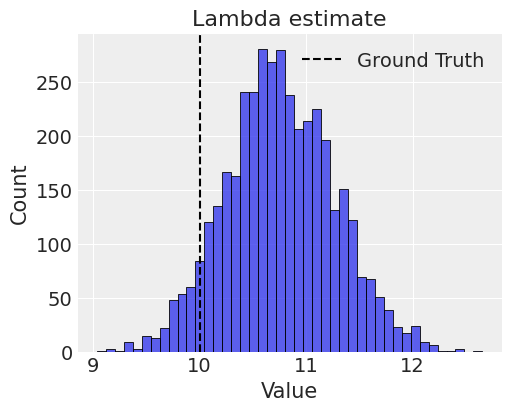

In [15]:
fig, ax = plt.subplots(figsize=(5,4))
sns.histplot( idata_demand['lambd'],ax=ax )
ax.axvline(10, ls='--', color='k', label='Ground Truth')
ax.legend()
ax.set(xlabel="Value", title="Lambda estimate")
plt.show()

Ok cool, now that we have a rental duration model and a rental demand model, lets build a simulation

# Part 3: Simulation
---

We can leverage numpyro to simulate this. They have a `scan` operator that basically iterates day over day which fits well with this problem. Here's the initial simulation model structure. 

If you look at the `model` method, it takes in an initial state, and iterates over the `model_single_day` method each day we tell it to. 

The `model_single_day` method simulates returns and rentals each day, and logs them.



```python
class RentalInventory:
	"""A model of rental inventory, modeling stock levels as returns and rentals occur each day.
	Currently supports a single product
	"""
	def __init__(self, n_products: int = 1, policies: Dict = {}):
		self.n_products = n_products
		self.policies = policies
		# Rentals that are out with customers are stored as an array, where the index corresponds with time, 
		# and the value corresponds with the number of rentals from that time that are still out with customers
		# max_periods is the total number of periods to log
		self.max_periods = 10000

	def model(self, init_state: Dict, start_time: int, end_time: int):
		_, ys = scan(
			self.model_single_day, 
			init=init_state, 
			xs=jnp.arange(start_time, end_time)
		)
		return ys

	def model_single_day(self, state, time):
		"""
		"""
		state_next = dict()

		# Simulate Returns
		returns = self.returns_model(state['existing_rentals'], time)
		state_next['starting_stock'] = numpyro.deterministic(
            "starting_stock", state['ending_stock'] + returns.sum() + self.apply_policy(time)
        )

		# Simulate Rentals, incorporate them into the next state
		rentals = self.demand_model(available_stock=state_next['starting_stock'], time=time)
		state_next['ending_stock'] = numpyro.deterministic("ending_stock", state_next['starting_stock'] - rentals.sum())
		state_next['existing_rentals'] = numpyro.deterministic(
            "existing_rentals", state['existing_rentals'] - returns + rentals
        )
		return state_next, rentals

    ...
```

The individual models themselves are similar to what we've already used. They are a little complicated and overwhelming with the array operations and logic however, so feel free to skim over this for now.

```python
class RentalInventory
    
    ...
    
	def returns_model(self, existing_rentals, time):
		theta = numpyro.sample("theta", dist.Normal(2.9, 0.01))
		sigma = numpyro.sample("sigma", dist.TruncatedNormal(0.7, 0.01, low=0))
		return_dist = dist.LogNormal(theta, sigma)

		# For each day of historical rentals that are currently rented, calculate how long they've been rented for
		rental_durations = (time-jnp.arange(self.max_periods))
		discrete_hazards = jnp.where(
			# If rental duration is nonnegative,
			rental_durations>0,
			# Use those rental durations to calculate a return rate, using a discrete interval hazard function
			RentalInventory.hazard_func(jnp.clip(rental_durations, a_min=0), dist=return_dist ),
			# Otherwise, return rate is 0
			0
		)
		returns = numpyro.sample("returns", dist.Binomial(existing_rentals ,probs=discrete_hazards))
		total_returns = numpyro.deterministic("total_returns", returns.sum())
		return returns

	def demand_model(self, available_stock, time):
		lambd = numpyro.sample("lambd", dist.Normal(10, 0.01))
		unconstrained_rentals = numpyro.sample("unconstrained_rentals", dist.Poisson(lambd))
		rentals = numpyro.deterministic("rentals", jnp.clip(unconstrained_rentals, a_min=0, a_max=available_stock ))
		rentals_as_arr = ( time == jnp.arange(self.max_periods) )*rentals
		return rentals_as_arr

	@staticmethod
	def hazard_func(t, dist):
		"""Discrete interval hazard function - aka the probability of a return occurring on a single date
		"""
		return (dist.cdf(t+1)-dist.cdf(t))/(1-dist.cdf(t))

	def apply_policy(self, time):
        """Adds in some number of units for the product at time $T=t$
        """
		return self.policies[time]
```

Lets dive in and simulate what would happen if we re-stocked different amounts

In [16]:
def get_active_rentals_as_array(rentals):
    """Each array element corresponds to a single day, and the value is the amount of active rentals that are still
    out with customers that started on that date
    """
    active_rentals = np.zeros(10000)
    dates = pd.date_range(rentals.date.min(), end=rentals.date.max(), freq='D').values
    active_rentals[:len(dates)] = (rentals.loc[lambda d: d.return_date.isnull()].date.values == dates[:,None]).sum(1)
    return active_rentals

In [17]:
from src.rental_model import RentalInventory

latest_stock_level = stock.tail(1)['units'].values[0]
active_rentals = get_active_rentals_as_array(rentals)
init_state = {
    "starting_stock": latest_stock_level,
    "ending_stock": latest_stock_level,
    "existing_rentals":active_rentals
}

# Try adding 50 new units at time T=100
reorder_policy = (jnp.arange(10000) == 100)*50


rental_inventory = RentalInventory(n_products = 1, policies=reorder_policy)

# Input our learned parameters from the previous models
rental_model = numpyro.handlers.condition(
    rental_inventory.model, 
    data={
        "lambd":idata_demand['lambd'].mean(), 
         "theta":idata['theta'].mean(),
         "sigma":idata['sigma'].mean()}
)

simulation = numpyro.infer.Predictive(
    rental_model, 
    num_samples = 250,
)
results = simulation(random.PRNGKey(1), init_state, start_time=100, end_time=200)

ModuleNotFoundError: No module named 'src'

Lets look at one potential outcome of the simulation. You can try re-running this multiple times to see a range of possible different outcomes that are all possible under this reorder policy. Most of these end up still being stocked out

In [ ]:
sample_idx = np.random.choice(250)

daily_rentals = np.concatenate((
    rentals.groupby("date").rental_id.count().reindex(stock.date,fill_value=0), 
    results['rentals'][sample_idx,:])
)
daily_stock = np.concatenate((stock.units.values, results['starting_stock'][sample_idx,:]))

ax = plot_rentals(daily_rentals, daily_stock)
ax.set(title='Simulated Stock Levels after Reordering 50 units')
ax.axvline(100, color='k', ls='--', label='Reorder')
ax.legend()
plt.show()

We can summarize all of these simulations with uncertainty intervals 

In [ ]:

dates = pd.date_range(start=rentals.date.min(), periods=200, freq='D')
# daily_rentals_sim = results['rentals']
daily_ending_stock_sim =  results['ending_stock']


fig, ax = plt.subplots(1,1,figsize=(12,5))
az.plot_hdi(dates[100:], daily_ending_stock_sim, smooth=False,ax=ax, color='r', fill_kwargs=dict(alpha=0.25),)
ax.plot(dates[100:], daily_ending_stock_sim.mean(0), color='r', ls='--', label='Simulated Stock Levels')
stock.set_index("date").ending_units.plot(color='k',ax=ax, label='Historical Stock Levels')
ax.axvline(dates[100], color='k',ls='--', label='Reorder')
ax.set(
    title='Simulated Stock Levels: what would happen after reordering 50 units?',
    ylabel='Stock Levels',
    xlabel='Date'
)

# Overlay some simulations to confirm its lining up with the plot
ax.plot(dates[100:], daily_ending_stock_sim[:20,:].T, alpha=0.1, color='k');
ax.plot(dates[100:], daily_ending_stock_sim[0,:].T, alpha=0.1, color='k',label='Individual Simulations');

ax.legend()
plt.show()

This view makes it a little more clear that there are probably stockouts happening, but it doesnt tell us for sure. 
We can actually calculate the stockout rate over time by averaging over all of the existing simulations and counting the number of simulations that have 0 stock each day.

We could also go back and update the simulator to log things like *"missed rentals due to stockouts"* or other quantities that might be helpful

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
p_stockout = (daily_ending_stock_sim==0).mean(0)
ax.plot(dates[100:200], p_stockout)
ax.axvline(dates[100], color='k', ls='--', label='Reorder Time')
ax.set(title='Estimated Stockout Probability after reordering 50 units', ylabel='Stockout Rate')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
plt.show()

Ok so clearly reordering 50 units isnt enough - so what should we reorder? 

We could just simulate repeatedly with different stock reorder inputs like below

In [ ]:
def sim_stockout_rate(stock_reorder):    
    latest_stock_level = stock.tail(1)['units'].values[0]
    active_rentals = get_active_rentals_as_array(rentals)
    init_state = {
        "starting_stock": float(latest_stock_level),
        "ending_stock": float(latest_stock_level),
        "existing_rentals":active_rentals
    }

    # Try adding x new units at time T=100
    reorder_policy = (jnp.arange(10000) == 100)*stock_reorder
    rental_inventory = RentalInventory(n_products = 1, policies=reorder_policy)

    # Input our learned parameters from the previous models
    rental_model = numpyro.handlers.condition(
        rental_inventory.model, 
        data={
            "lambd":idata_demand['lambd'].mean(), 
             "theta":idata['theta'].mean(),
             "sigma":idata['sigma'].mean()}
    )

    simulation = numpyro.infer.Predictive(rental_model, num_samples = 100)
    results = simulation(random.PRNGKey(1), init_state, start_time=100, end_time=200)
    stockout_rate = (results['ending_stock']==0).mean(0).mean()
    
    return stockout_rate

In [ ]:
results = np.empty((15,2))
for i, units in enumerate(range(0,150, 10)):
    stockout_rate = sim_stockout_rate(units)
    results[i,:] = [units, stockout_rate]

fig, ax = plt.subplots()
ax.plot(results[:,0], results[:,1])
ax.set(ylabel='Est. Stockout Rate', xlabel='Units Reordered', title='Estimated Stockout Rate as we reorder more units')
plt.show()

Its clear that right around 100 units is when the probability of a stockout gets really low. We could speed this up if we wanted by building an optimizer. One simple way might be to build a binary search algorithm that gets you the minimum amount of stock without having any stockouts.

Thats an exercise for another time. Lets reorder 100 units like we're recommending and see what happens

In [ ]:
# Try adding x new units at time T=100
reorder_policy = (jnp.arange(10000) == 100)*100
rental_inventory = RentalInventory(n_products = 1, policies=reorder_policy)

# only simulate 1 sample - we're going to pretend we actually reordered 50 units 
# and watched what happened afterward
observe_future = numpyro.infer.Predictive(
    rental_inventory.model, 
    num_samples = 1,
)
results = observe_future(random.PRNGKey(99), init_state, start_time=100, end_time=200)


In [ ]:
dates = pd.date_range(start=rentals.date.min(), periods=200, freq='D')
daily_ending_stock_sim =  results['ending_stock'].ravel()


fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(dates[100:], daily_ending_stock_sim, color='k')
stock.set_index("date").ending_units.plot(color='k',ax=ax, label='Historical Stock Levels')
ax.axvline(dates[100], color='k',ls='--', label='Reorder')
ax.set(
    title='Observed Stock Levels after reordering 100 units',
    ylabel='Stock Levels',
    xlabel='Date'
)
ax.axhline(0, color='r')
ax.legend()
plt.show()

Amazing, by reordering 100 units, we no longer ran into any stockouts! This is exactly what we were hoping for. 

We now have a system we can use to figure out the optimal stock to reorder for a single product. How can we now scale this to our entire inventory, or even inform the purchasing of new products?

# Next Steps: Simulating a full product assortment

---

We're going to borrow ideas from discrete choice literature (see [Kenneth Train's Discrete Choice Methods with Simulation](https://eml.berkeley.edu/books/choice2.html)) - each product has some inherent utility, $U$, which determines how often its chosen. 

A decision maker, $n$, has $J$ products they can choose from. The utility of a given product, $j$ for a given user $n$ is 

$$
U_{nj} \sim \beta \: x_{nj} + \epsilon_{nj}
$$

where $\epsilon_{nj}$ is an error term that follows a Gumbel distribution. 

Why are we using this seemingly complicated representation? It has some really nice properties - namely that utilities are easy to convert to choice probabilities, even when the choice set (in this case the available product catalog) changes. All you have to do is take your utilities and feed them into a softmax equation to get choice probabilities for each product.

This is particularly helpful for this sort of problem, because the choice set is frequently changing for customers as products go in and out of stock.

We're going to make one key simplification here - we're going to measure utility for the population as a whole, and not condition on individual user features - since our goal right now is just to know how much stock to reorder, we dont really need to know heterogeneity in demand across users unless we expect a big shift in our customer base in the near term. 


[In Progress]